In [1]:
import pickle as pkl
import viz_sequence
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import h5py
from scipy.special import softmax
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

#uncorrected model paths
model_5M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.01.2021_subsample_5M/with_k562_bias_final_model/"
model_25M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.30.2021_subsample_25M/with_k562_bias_final_model/"
model_50M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.01.2021_subsample_50M/with_k562_bias_final_model/"
model_100M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.30.2021_subsample_100M/with_k562_bias_final_model/"
model_500M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.29.2021_bias_filters_500/final_model_step3/"

#corrected model paths
#model_5M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.01.2021_subsample_5M/with_k562_bias_final_model/unplug/"
#model_25M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.30.2021_subsample_25M/with_k562_bias_final_model/unplug/"
#model_50M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.01.2021_subsample_50M/with_k562_bias_final_model/unplug/"
#model_100M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.30.2021_subsample_100M/with_k562_bias_final_model/unplug/"
#model_500M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.29.2021_bias_filters_500/final_model_step3/unplug/"
import numpy as np
from scipy.stats import entropy

In [12]:
def load_data(model_path, val_key):
    f1=model_path+"deepshap/scores.xaa.fold0.deepSHAP"
    f2=model_path+"deepshap/scores.xab.fold0.deepSHAP"
    f3=model_path+"deepshap/scores.xac.fold0.deepSHAP"
    fileso = [f1, f2, f3]
    
    out_keys = []
    values = []

    data3 = {}
    
    for fin in fileso:
        data2 = pkl.load(open(fin, "rb"))
        for key in data2[val_key]:
            if key not in data3:
                if "shap" not in val_key:
                    data3[key] = data2[val_key][key]
                    break
                else:
                    data3[key] = np.abs(np.sum(data2[val_key][key]*data2["seq"][key],axis=1))[1057-500:1057+500]                    
            else:
                print(key)
                        
    return data3

In [13]:
#count_shap, profile_shap, pred_prof, pred_sum, label_prof, label_sum
val_key="pred_prof"
data_500M =  load_data(model_500M, val_key)
data_100M = load_data(model_100M, val_key)
data_50M = load_data(model_50M, val_key)
data_25M = load_data(model_25M, val_key)
data_5M = load_data(model_5M, val_key)

0.9999992737137582
1.000000830136969
0.9999998903685992
0.9999995405118813
1.0000000393663413
1.0000011011971708
0.9999991047501755
0.9999990419062215
1.0000006672881057
1.0000003963698596
0.9999998227660853
0.9999996733652949
0.9999999360618279
0.9999994917050117
1.0000005636292428


In [4]:
def jsd_pred(profile1_preds, profile2_preds):
    jsd_vals=[]
    for key in profile1_preds:
        jsd_val = jensenshannon(profile1_preds[key], profile2_preds[key])
        if np.isnan(jsd_val):
            #print(np.sum(profile1_preds[key]),np.sum(profile2_preds[key]))
            pass
        else:
            jsd_vals.append(jsd_val)
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals

In [5]:
stats_500Mv100M, vals_500Mv100M = jsd_pred(data_500M, data_100M)
print("500M vs 100M JSD", stats_500Mv100M)
stats_500Mv50M, vals_500Mv50M = jsd_pred(data_500M, data_50M)
print("500M vs 50M JSD", stats_500Mv50M)
stats_500Mv25M, vals_500Mv25M = jsd_pred(data_500M, data_25M)
print("500M vs 25M JSD", stats_500Mv25M)
stats_500Mv5M, vals_500Mv5M = jsd_pred(data_500M, data_5M)
print("500M vs 5M JSD", stats_500Mv5M)

500M vs 100M JSD [0.08673711397858204, 0.025404517058718167]
500M vs 50M JSD [0.10575864683277135, 0.03520385613082759]
500M vs 25M JSD [0.10992122946485529, 0.03472616596569872]
500M vs 5M JSD [0.12362397611896012, 0.0389659327881042]


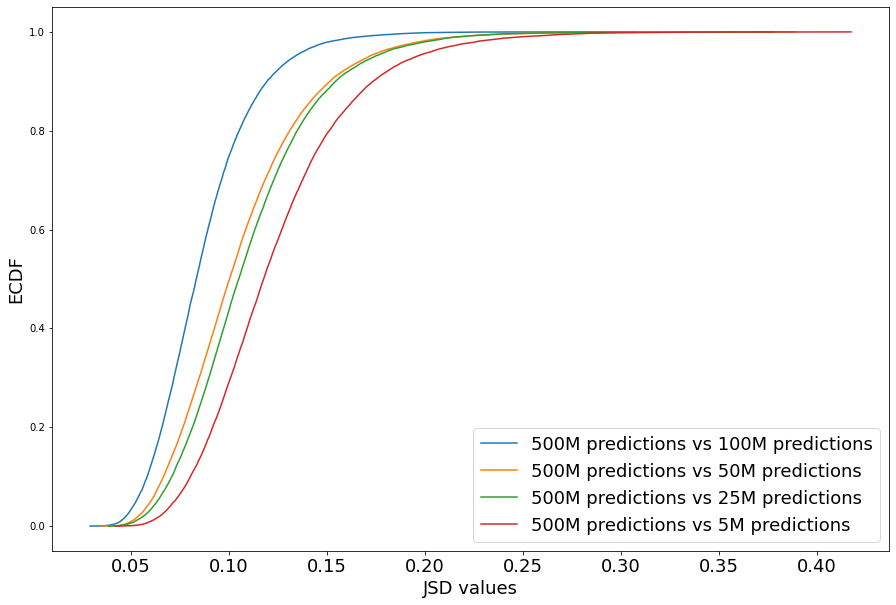

In [6]:

plt.figure(figsize=(15, 10))
title="predictions"
title1=title
ecdf = ECDF(vals_500Mv100M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 100M " +title1)
ecdf = ECDF(vals_500Mv50M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 50M " +title1)
ecdf = ECDF(vals_500Mv25M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 25M " +title1)
ecdf = ECDF(vals_500Mv5M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 5M " +title1)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("JSD values", fontsize=18)
plt.ylabel("ECDF", fontsize=18)
plt.show()

In [8]:
np.random.seed(1)
def normed_jsd(profile_preds_500M, profile_preds, obs_500M):
    jsd_vals=[]
    for i in range(profile_preds.shape[0]):
        x = jensenshannon(profile_preds[i], obs_500M[i])
        max_v = jensenshannon(profile_preds_500M[i], obs_500M[i])
        #j = np.random.choice(list( range(profile_preds.shape[0])),1)[0]
        #min_v = jensenshannon(profile_preds[i], obs_500M[j])
        #print(x, max_v, min_v)
        if not np.isnan(x):
            jsd_vals.append((x-1)/(max_v-1))
        #break
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals

In [9]:
stats_500Mv100M, vals_500Mv100M = normed_jsd(data_500M, data_100M)
print("500M vs 100M JSD", stats_500Mv100M)
stats_500Mv50M, vals_500Mv50M = normed_jsd(data_500M, data_50M)
print("500M vs 50M JSD", stats_500Mv50M)
stats_500Mv25M, vals_500Mv25M = normed_jsd(data_500M, data_25M)
print("500M vs 25M JSD", stats_500Mv25M)
stats_500Mv5M, vals_500Mv5M = normed_jsd(data_500M, data_5M)
print("500M vs 5M JSD", stats_500Mv5M)

TypeError: normed_jsd() missing 1 required positional argument: 'obs_500M'

In [ ]:

plt.figure(figsize=(15, 10))
title="predictions"
title1=title
ecdf = ECDF(vals_500Mv100M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 100M " +title1)
ecdf = ECDF(vals_500Mv50M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 50M " +title1)
ecdf = ECDF(vals_500Mv25M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 25M " +title1)
ecdf = ECDF(vals_500Mv5M)
plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 5M " +title1)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("JSD values", fontsize=18)
plt.ylabel("ECDF", fontsize=18)
plt.show()